In [74]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [75]:
SEED = 42

In [76]:
spark = SparkSession.builder.appName("BigData projekt model").getOrCreate()

In [77]:
df = spark.read.csv("data/mountains_vs_beaches_preferences.csv",
                    sep=';',
                    inferSchema=True,
                    header=True)

In [78]:
df.show()

+---+----------+------+---------------+----------------+--------------------+---------------+--------+----------------------+--------------------+---------------+----+----------------------+----------+
|Age|    Gender|Income|Education_Level|Travel_Frequency|Preferred_Activities|Vacation_Budget|Location|Proximity_to_Mountains|Proximity_to_Beaches|Favorite_Season|Pets|Environmental_Concerns|Preference|
+---+----------+------+---------------+----------------+--------------------+---------------+--------+----------------------+--------------------+---------------+----+----------------------+----------+
| 56|      male| 71477|       bachelor|               9|              skiing|           2477|   urban|                   175|                 267|         summer|   0|                     1|         1|
| 69|      male| 88740|         master|               1|            swimming|           4777|suburban|                   228|                 190|           fall|   0|                     1|  

In [79]:
print("Schema:")
df.printSchema()

Schema:
root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Travel_Frequency: integer (nullable = true)
 |-- Preferred_Activities: string (nullable = true)
 |-- Vacation_Budget: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Proximity_to_Mountains: integer (nullable = true)
 |-- Proximity_to_Beaches: integer (nullable = true)
 |-- Favorite_Season: string (nullable = true)
 |-- Pets: integer (nullable = true)
 |-- Environmental_Concerns: integer (nullable = true)
 |-- Preference: integer (nullable = true)



In [80]:
# Indeksowanie kolumn typu string (zakodowanie ich na wartości numeryczne)
string_cols = [field.name for field in df.schema.fields if str(field.dataType) == 'StringType()']
print(string_cols)

['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season']


In [81]:
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    df = indexer.fit(df).transform(df)

In [82]:
# Sprawdzenie schematu danych
print("Schema:")
df.printSchema()


Schema:
root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Travel_Frequency: integer (nullable = true)
 |-- Preferred_Activities: string (nullable = true)
 |-- Vacation_Budget: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Proximity_to_Mountains: integer (nullable = true)
 |-- Proximity_to_Beaches: integer (nullable = true)
 |-- Favorite_Season: string (nullable = true)
 |-- Pets: integer (nullable = true)
 |-- Environmental_Concerns: integer (nullable = true)
 |-- Preference: integer (nullable = true)
 |-- Gender_indexed: double (nullable = false)
 |-- Education_Level_indexed: double (nullable = false)
 |-- Preferred_Activities_indexed: double (nullable = false)
 |-- Location_indexed: double (nullable = false)
 |-- Favorite_Season_indexed: double (nullable = false)



In [83]:
# Zbiór cech do modelu
feature_columns = [f"{col}_indexed" if col in string_cols else col for col in df.columns if col != "Preference"]
print(feature_columns)

['Age', 'Gender_indexed', 'Income', 'Education_Level_indexed', 'Travel_Frequency', 'Preferred_Activities_indexed', 'Vacation_Budget', 'Location_indexed', 'Proximity_to_Mountains', 'Proximity_to_Beaches', 'Favorite_Season_indexed', 'Pets', 'Environmental_Concerns', 'Gender_indexed', 'Education_Level_indexed', 'Preferred_Activities_indexed', 'Location_indexed', 'Favorite_Season_indexed']


In [84]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
print(assembler)

VectorAssembler_c3a94d8ae71e


In [85]:
# Normalizacja danych
# scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

In [86]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Preference", featuresCol="features", seed=SEED)

In [87]:
# Pipeline: indeksowanie + łączenie cech + model
pipeline = Pipeline(stages=[assembler, rf])

In [88]:
# Podział danych na zbiór treningowy i testowy
train, test = df.randomSplit([0.7, 0.3], SEED)

In [89]:
# Trening modelu
model = pipeline.fit(train)

In [90]:
# Ewaluacja modelu
predictions = model.transform(test)
predictions.select("features", "Preference", "prediction").show()

+--------------------+----------+----------+
|            features|Preference|prediction|
+--------------------+----------+----------+
|[18.0,0.0,20312.0...|         0|       0.0|
|[18.0,0.0,20848.0...|         0|       0.0|
|[18.0,0.0,21186.0...|         1|       1.0|
|[18.0,0.0,21583.0...|         0|       0.0|
|[18.0,0.0,23403.0...|         0|       0.0|
|[18.0,0.0,23829.0...|         0|       0.0|
|[18.0,0.0,25711.0...|         1|       1.0|
|[18.0,0.0,26859.0...|         1|       1.0|
|(18,[0,2,6,7,8,9,...|         0|       0.0|
|(18,[0,2,3,4,6,8,...|         0|       0.0|
|[18.0,0.0,27140.0...|         0|       0.0|
|(18,[0,2,3,4,6,8,...|         0|       0.0|
|[18.0,0.0,27901.0...|         0|       0.0|
|[18.0,0.0,27971.0...|         0|       0.0|
|[18.0,0.0,28668.0...|         0|       0.0|
|[18.0,0.0,29675.0...|         0|       0.0|
|[18.0,0.0,29772.0...|         0|       0.0|
|[18.0,0.0,31168.0...|         1|       1.0|
|[18.0,0.0,31451.0...|         0|       0.0|
|[18.0,0.0

In [91]:
pred_result = predictions.groupBy('Preference', 'prediction').count()
pred_result.show()

+----------+----------+-----+
|Preference|prediction|count|
+----------+----------+-----+
|         1|       0.0|  206|
|         0|       0.0|11514|
|         1|       1.0| 3730|
|         0|       1.0|  243|
+----------+----------+-----+



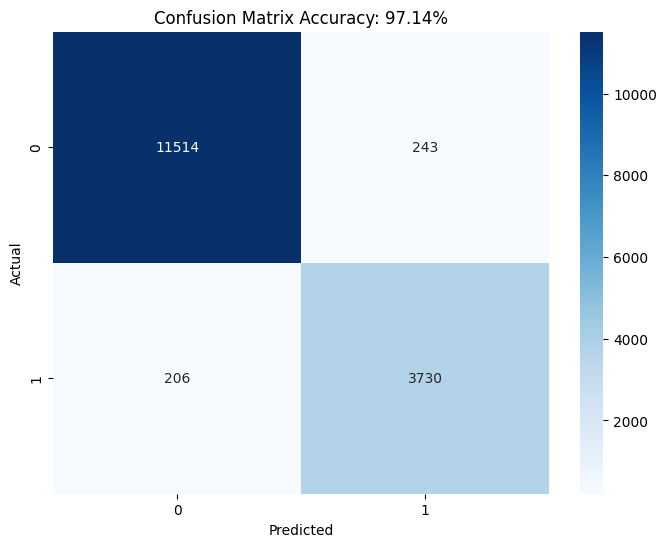

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = pred_result.toPandas()
matrix = np.zeros((2, 2))
for _, row in conf_matrix.iterrows():
    true_label = int(row["Preference"])
    pred_label = int(row["prediction"])
    count = int(row["count"])
    matrix[true_label][pred_label] = count

conf_matrix_df = pd.DataFrame(matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title(f"Confusion Matrix Accuracy: {np.trace(matrix)/np.sum(matrix)*100:.2f}%")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [93]:
model.write().overwrite().save('./model/RandomForestClassifier')

In [94]:
# Zatrzymanie SparkSession
# spark.stop()

+----------+----------+-----+
|Preference|prediction|count|
+----------+----------+-----+
|         1|       0.0|  670|
|         0|       0.0|38522|
|         1|       1.0|12478|
|         0|       1.0|  774|
+----------+----------+-----+



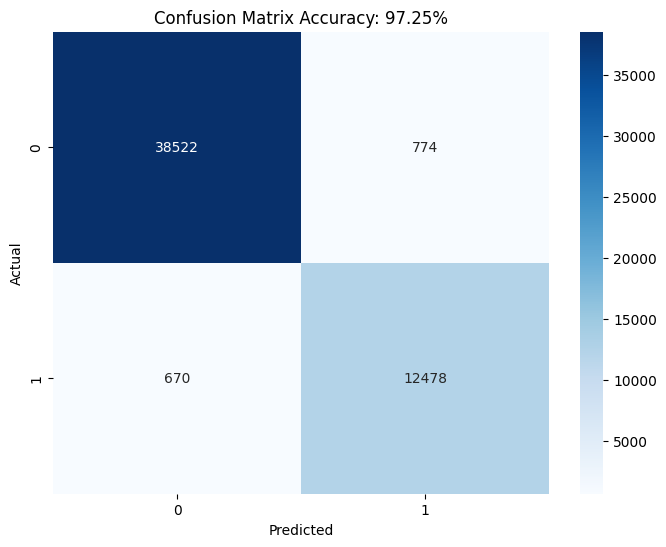

In [95]:
# Indeksowanie kolumn typu string (zakodowanie ich na wartości numeryczne)
full_df = df
# string_cols = [field.name for field in df.schema.fields if str(field.dataType) == 'StringType()']
# print(string_cols)
# for col in string_cols:
#     indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
#     full_df = indexer.fit(full_df).transform(full_df)
    
# Ewaluacja modelu
full_data_predictions = model.transform(full_df)
# full_data_predictions.select("features", "Preference", "prediction").show()

full_data_pred_result = full_data_predictions.groupBy('Preference', 'prediction').count()

full_data_conf_matrix = full_data_pred_result.toPandas()

full_data_matrix = np.zeros((2, 2))
for _, row in full_data_conf_matrix.iterrows():
    true_label = int(row["Preference"])
    pred_label = int(row["prediction"])
    count = int(row["count"])
    full_data_matrix[true_label][pred_label] = count

full_data_conf_matrix_df = pd.DataFrame(full_data_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(full_data_conf_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title(f"Confusion Matrix Accuracy: {np.trace(full_data_matrix)/np.sum(full_data_matrix)*100:.2f}%")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
